# What is hidden in a randomly weighted neural network?

This is a small implementation of a fully connected neural network in numpy/cupy ( i switched to the latter since it took a long time on CPU, pretty interchangeable save for some parts of the code where the cupy array has to be converted to numpy array)

TL ; DR of the paper : Chonky neural nets contains wisdom. 

The paper explores the posibility of finding a good subnetwork inside a randomly initialized neural network that could perform well on a certain task. How the authors approach finding this subnetwork is by assigning a score corresponding to each weights, and during feedforward, only weights with a top K % score is considered. Optimization is done on the score, while weights are kept constant.

In this implementation, i observe how both approaches perform on a similar task : Digits classification in MNIST.

In [1]:
# import numpy as np
import cupy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(69420)

# Implementation : Baseline

Since we need a comparison, we will first see how would a fully connected NN trained with normal backprop perform.

In [3]:
def glorot_init(shape):
    fan_out,fan_in = shape
    limit = np.sqrt(6/(fan_in+fan_out))
    params = np.random.uniform(low=limit*-1,high=limit,size=shape)
    return params

In [4]:
def kaiming_uniform(shape):
    fan_out, fan_in = shape
    params = np.random.normal(loc=0,scale=np.sqrt(2/fan_in),size=shape)
    return params

In [5]:
def relu(a,prime=False):
    if not prime:
        mask = a > 0
        return a * mask
    else:
        mask = a > 0
        return mask.astype(np.float32)

In [6]:
def softmax(a,prime=False):
    a = np.exp(a)
    a = a / np.sum(a,axis=0)
    return a

In [7]:
def targets_to_onehot(targets,numclass):
    onehot = np.zeros((numclass,len(targets)))
    onehot[targets,np.arange(len(targets))] = 1
    return onehot

In [8]:
def crossentropy_with_logits(logits_out, y,prime=False):
    num_classes, num_samples = logits_out.shape
    y_onehot = targets_to_onehot(y,num_classes)
    assert logits_out.shape == y_onehot.shape
    softmaxed = softmax(logits_out)
    if prime:
        softmaxed[y,np.arange(num_samples)] -=1
        return softmaxed
    else:
        return np.sum(np.nan_to_num(y_onehot * np.log(softmaxed) + (1-y_onehot) * np.log((1-softmaxed))))

In [9]:
def SGDOptimizer(gradients,parameters,learningrate):
    parameters = [p - learningrate * g for p,g in zip(parameters,gradients)]
    return parameters

In [10]:
def MomentumSGD(lr,m):
    vl = None
    def optimizer(grads,params):
        nonlocal vl
        if vl is None:
            vl = [np.zeros(p.shape) for p in params]
        vl = [m * v + lr * g for v,g in zip(vl,grads)]
        params = [p-v for p,v in zip(params,vl)]
        return params    
    return optimizer

In [11]:
class FCNN(object):
    
    def __init__(self, layers_size,initializer_weight,initializer_bias,activation,loss_function,optimizer_w,optimizer_b):
        self.layers_size = layers_size
        self.weights = [initializer_weight((k,j)) for j,k in zip(layers_size[:-1],layers_size[1:])]
        self.biases = [initializer_bias((k,1)) for k in layers_size[1:]]
        self.activation = activation
        self.loss_function = loss_function
        self.optimizer_w = optimizer_w
        self.optimizer_b = optimizer_b
    
    def feedforward(self,X):
        a = X
        zs = []
        acs = [a]
        for w,b in zip(self.weights,self.biases):
            a = np.dot(w,a) + b
#             print(a.shape)
            zs.append(a)
            a = self.activation(a)
            acs.append(a)
        return a, zs, acs
    
    def feedforward_softmax(self,X):
        final_a, _, _ = self.feedforward(X)
        final_a = np.exp(final_a)
#         print(final_a.shape)
        final_a = final_a / np.sum(final_a,axis=0)
        return final_a
    
    def backpropagation(self,X,y):
        input_dim, batch_size = X.shape
        final_activation, zs, acs = self.feedforward(X)
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b = [np.zeros(b.shape) for b in self.biases]
        error = self.loss_function(final_activation,y,prime=True) * self.activation(zs[-1],True)
        delta_w[-1] += np.einsum('ik,jk->ijk',error,acs[-2]).mean(axis=2)
        delta_b[-1] += np.expand_dims(error,1).mean(axis=2)
        for i in range(2,len(self.layers_size)):
            error = np.einsum('ik,ij->jk',error,self.weights[-i+1]) * self.activation(zs[-i],prime=True)
            delta_w[-i] += np.einsum('ik,jk->ijk',error,acs[-i-1]).mean(axis=2)
            delta_b[-i] += np.expand_dims(error,1).mean(axis=2) 
        return delta_w, delta_b
    
    def fit(self,X,y,batch_size,epochs):
        # expecting X and y to be already numpy array with the num_samples as 
        # 1st dim
        history = np.zeros(epochs + 1)
        history -= 1
        index = 0
        for epoch in range(epochs):
            indices = np.arange(X.shape[0],dtype=np.int32)
            np.random.shuffle(indices)
            X = X.copy()[indices,:]
            y = y.copy()[indices]
            i = 0
            batches_X = [X[k:k+batch_size] for k in range(0,X.shape[0],batch_size)]
            batches_y = [y[k:k+batch_size] for k in range(0,y.shape[0],batch_size)]
            losses = 0
            if index == 0:
                for Xb, yb in zip(batches_X,batches_y):
                    logits,_,_ = self.feedforward(Xb.T)
                    history[0] += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
            for Xb, yb in zip(batches_X,batches_y):
                delta_w, delta_b = self.backpropagation(Xb.T, yb.T)
#                 print(delta_w)
                self.weights = self.optimizer_w(delta_w,self.weights)
                self.biases = self.optimizer_b(delta_b,self.biases)
                logits,_,_ = self.feedforward(Xb.T)
                losses += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
#                 print((Xb.shape[0] * len(batches_X)))
            history[index] = losses
            index += 1
            print(f"Epoch {epoch} done. Loss : {losses}")
        return history
    
    def predict(self,X):
        softmaxed = self.feedforward_softmax(X.T)
        preds = np.argmax(softmaxed,axis=0)
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        assert preds.shape == y.shape
        return np.mean(preds == y) * 100

In [12]:
mnist_data = np.load('../Dataset/Mnist/train.npy')

In [13]:
mnist_label = mnist_data[:,0]
mnist_pixels = mnist_data[:,1:] / 255

In [14]:
smol_batch_pixels = mnist_pixels[:32,:]
smol_batch_label = mnist_label[:32].astype(np.int32)

In [15]:
weight_optimizer = MomentumSGD(0.001,0.9)
bias_optimizer = MomentumSGD(0.001,0.9)
nn_overfit = FCNN([784,100,100,10],kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,weight_optimizer,bias_optimizer)

In [16]:
hist = nn_overfit.fit(smol_batch_pixels,smol_batch_label,32,1000)

Epoch 0 done. Loss : -3.749897180894854
Epoch 1 done. Loss : -3.682271576986854
Epoch 2 done. Loss : -3.6035557455315725
Epoch 3 done. Loss : -3.524958694301793
Epoch 4 done. Loss : -3.4521233438296495
Epoch 5 done. Loss : -3.3863179595712936
Epoch 6 done. Loss : -3.326984844858233
Epoch 7 done. Loss : -3.272507119815727
Epoch 8 done. Loss : -3.2225475436691395
Epoch 9 done. Loss : -3.1742886049148593
Epoch 10 done. Loss : -3.1295937742786153
Epoch 11 done. Loss : -3.090815039681315
Epoch 12 done. Loss : -3.0583340538066777
Epoch 13 done. Loss : -3.0299311680301093
Epoch 14 done. Loss : -3.0065050339187893
Epoch 15 done. Loss : -2.9877819564389
Epoch 16 done. Loss : -2.9730377988787353
Epoch 17 done. Loss : -2.9607982252199583
Epoch 18 done. Loss : -2.9515256536750374
Epoch 19 done. Loss : -2.944579446683294
Epoch 20 done. Loss : -2.93923338426746
Epoch 21 done. Loss : -2.932552790172003
Epoch 22 done. Loss : -2.922423843219667
Epoch 23 done. Loss : -2.90843088878648
Epoch 24 done. Los

Epoch 215 done. Loss : -1.8952339064433565
Epoch 216 done. Loss : -1.8939455899668347
Epoch 217 done. Loss : -1.8926414683822967
Epoch 218 done. Loss : -1.891330622304981
Epoch 219 done. Loss : -1.890029269149288
Epoch 220 done. Loss : -1.8887399371788973
Epoch 221 done. Loss : -1.8874870521921034
Epoch 222 done. Loss : -1.8862615884719216
Epoch 223 done. Loss : -1.885066548822278
Epoch 224 done. Loss : -1.8838812459478917
Epoch 225 done. Loss : -1.882702086325273
Epoch 226 done. Loss : -1.8815376465421618
Epoch 227 done. Loss : -1.8803926742377537
Epoch 228 done. Loss : -1.879265933016892
Epoch 229 done. Loss : -1.8781801818224377
Epoch 230 done. Loss : -1.8770536271469291
Epoch 231 done. Loss : -1.8759139125378028
Epoch 232 done. Loss : -1.874771445388541
Epoch 233 done. Loss : -1.8736605366412609
Epoch 234 done. Loss : -1.8725554848473556
Epoch 235 done. Loss : -1.871424262898949
Epoch 236 done. Loss : -1.8702809265444356
Epoch 237 done. Loss : -1.8691527675742723
Epoch 238 done. Lo

Epoch 416 done. Loss : -1.7769216229833087
Epoch 417 done. Loss : -1.7767083556962506
Epoch 418 done. Loss : -1.776489120082767
Epoch 419 done. Loss : -1.7762620596481773
Epoch 420 done. Loss : -1.7760155383253697
Epoch 421 done. Loss : -1.7758060176911128
Epoch 422 done. Loss : -1.7755919220836562
Epoch 423 done. Loss : -1.7754003200488453
Epoch 424 done. Loss : -1.77520291246819
Epoch 425 done. Loss : -1.774980302424369
Epoch 426 done. Loss : -1.77474800452253
Epoch 427 done. Loss : -1.7745360546064886
Epoch 428 done. Loss : -1.7743255465285592
Epoch 429 done. Loss : -1.774144848509482
Epoch 430 done. Loss : -1.7739645408758538
Epoch 431 done. Loss : -1.7737618838608773
Epoch 432 done. Loss : -1.773543876780049
Epoch 433 done. Loss : -1.7733208322389378
Epoch 434 done. Loss : -1.773117866268997
Epoch 435 done. Loss : -1.7729321105534228
Epoch 436 done. Loss : -1.7727466425356673
Epoch 437 done. Loss : -1.7725638443321778
Epoch 438 done. Loss : -1.7723912475670915
Epoch 439 done. Loss

Epoch 628 done. Loss : -1.750246990235238
Epoch 629 done. Loss : -1.7501942357555187
Epoch 630 done. Loss : -1.7501184092420965
Epoch 631 done. Loss : -1.7500400582381062
Epoch 632 done. Loss : -1.7499770205336436
Epoch 633 done. Loss : -1.7499020502999934
Epoch 634 done. Loss : -1.7498243792374921
Epoch 635 done. Loss : -1.749766024086258
Epoch 636 done. Loss : -1.7496883129403893
Epoch 637 done. Loss : -1.749601867860132
Epoch 638 done. Loss : -1.7495096514191717
Epoch 639 done. Loss : -1.7494740728426115
Epoch 640 done. Loss : -1.7493842425409176
Epoch 641 done. Loss : -1.7493646040422175
Epoch 642 done. Loss : -1.7493490707613042
Epoch 643 done. Loss : -1.7493091098694942
Epoch 644 done. Loss : -1.749252371205976
Epoch 645 done. Loss : -1.7491775056820182
Epoch 646 done. Loss : -1.749093219886229
Epoch 647 done. Loss : -1.749046187384429
Epoch 648 done. Loss : -1.7489660300413097
Epoch 649 done. Loss : -1.748909384153961
Epoch 650 done. Loss : -1.7488381999274771
Epoch 651 done. Lo

Epoch 832 done. Loss : -1.7413544249358646
Epoch 833 done. Loss : -1.7413322504982003
Epoch 834 done. Loss : -1.7413096108730222
Epoch 835 done. Loss : -1.7412823057583102
Epoch 836 done. Loss : -1.7412475466093955
Epoch 837 done. Loss : -1.741206758692646
Epoch 838 done. Loss : -1.7411698017013775
Epoch 839 done. Loss : -1.7411429816718205
Epoch 840 done. Loss : -1.7411144774669542
Epoch 841 done. Loss : -1.7410966617943735
Epoch 842 done. Loss : -1.7410726175926203
Epoch 843 done. Loss : -1.741038546126815
Epoch 844 done. Loss : -1.741007738587649
Epoch 845 done. Loss : -1.7409839080830385
Epoch 846 done. Loss : -1.740962609232453
Epoch 847 done. Loss : -1.74092799533366
Epoch 848 done. Loss : -1.740908410556358
Epoch 849 done. Loss : -1.7408854545969163
Epoch 850 done. Loss : -1.7408564641686257
Epoch 851 done. Loss : -1.7408180690019672
Epoch 852 done. Loss : -1.7407942045558735
Epoch 853 done. Loss : -1.7407598067061687
Epoch 854 done. Loss : -1.7407560533267588
Epoch 855 done. Lo

In [17]:
samples = mnist_pixels[:120,:]
samples_y =  mnist_label[:120]

In [18]:
nn_overfit.score(smol_batch_pixels,smol_batch_label)

array(46.875)

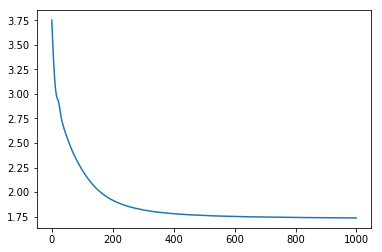

In [19]:
plt.figure()
plt.plot(-1 * np.asnumpy(hist[hist != -1]))

## Now for the actual training

In [20]:
weight_optimizer = MomentumSGD(0.001,0.9)
bias_optimizer = MomentumSGD(0.001,0.9)
nn = FCNN([784,100,100,10],kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,weight_optimizer,bias_optimizer)

In [21]:
indices = np.arange(len(mnist_label),dtype=np.int32)
np.random.shuffle(indices)

#### Data is p big lets save 10% for test (around 420 for each classes)

In [22]:
cutoff = int(len(indices) * 0.9)

In [23]:
indices_train = indices[:cutoff]
indices_test = indices[cutoff:]

In [24]:
train_pix, train_lab = mnist_pixels[indices_train], mnist_label[indices_train].astype(np.int32)
test_pix, test_lab = mnist_pixels[indices_test], mnist_label[indices_test].astype(np.int32)

In [25]:
fit_history = nn.fit(train_pix,train_lab,32,30)

Epoch 0 done. Loss : -2.4802696535794917
Epoch 1 done. Loss : -2.009661014390803
Epoch 2 done. Loss : -1.7308973423293676
Epoch 3 done. Loss : -1.386876585273928
Epoch 4 done. Loss : -1.0678495731406326
Epoch 5 done. Loss : -1.0122846991639363
Epoch 6 done. Loss : -0.980201576513601
Epoch 7 done. Loss : -0.9551785397439634
Epoch 8 done. Loss : -0.9352621267967882
Epoch 9 done. Loss : -0.9174188928238542
Epoch 10 done. Loss : -0.9037583537324133
Epoch 11 done. Loss : -0.890639400793885
Epoch 12 done. Loss : -0.8784535629246161
Epoch 13 done. Loss : -0.8685471745774762
Epoch 14 done. Loss : -0.8577273466565674
Epoch 15 done. Loss : -0.8493724076044776
Epoch 16 done. Loss : -0.8404698227420342
Epoch 17 done. Loss : -0.8319384617234646
Epoch 18 done. Loss : -0.8255263771825812
Epoch 19 done. Loss : -0.8181351910809391
Epoch 20 done. Loss : -0.6688311741366602
Epoch 21 done. Loss : -0.34378259614937046
Epoch 22 done. Loss : -0.23832538189819832
Epoch 23 done. Loss : -0.2203512101311073
Epoc

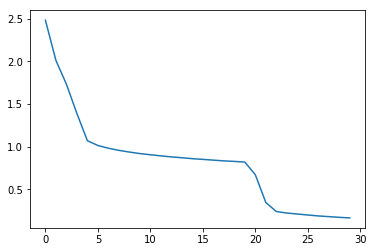

In [26]:
plt.figure()
plt.plot(np.asnumpy(fit_history[fit_history != -1]) * -1)

## Performance of FCNN trained with normal backpropagation

This is our performance using normal FCNN

In [27]:
print(f"Performance on training data : {nn.score(train_pix,train_lab)} %")

Performance on training data : 97.47619047619047 %


In [28]:
print(f"Performance on test data : {nn.score(test_pix,test_lab)} %")

Performance on test data : 95.54761904761905 %


**Not good, but eh, not our main goal.**

# Score-trained NN

Just remember to make it extra wide.

In [29]:
class ScoreFCNN(object):
    
    def __init__(self, layers_size,topKPercentage,initializer_weight,initializer_score,activation,loss_function,optimizer):
#         assert len(layers_size) == (len(topKPercentage)+1)
        self.layers_size = layers_size
        self.weights = [initializer_weight((k,j)) for j,k in zip(layers_size[:-1],layers_size[1:])]
        self.scores = [initializer_score(w.shape) for w in self.weights]
        self.topK = [int(j*k*topKPercentage) for j,k in zip(layers_size[:-1],layers_size[1:])]
        assert len(self.weights) == len(self.scores)
        self.activation = activation
        self.loss_function = loss_function
        self.optimizer = optimizer
    
    def feedforward(self,X):
        a = X
        zs = []
        acs = [a]
        for w,s,k in zip(self.weights,self.scores,self.topK):
            ss = s.copy()
            ww = w.copy()
#             assert not np.shares_memory(ss,s)
#             assert not np.shares_memory(ww,w)
#             ss = np.abs(ss)
            ss_flat = ss.ravel()
            sort_idx = ss_flat.argsort()
            ss_flat[sort_idx[-k:]] = 1
            ss_flat[sort_idx[:-k]] = 0
            assert ss.shape == w.shape
            ww = ww * ss
#             print(ww)
#             print(ww.shape)
            a = np.dot(ww,a)
            zs.append(a)
            a = self.activation(a)
            acs.append(a)
        return a, zs, acs
    
    def feedforward_softmax(self,X):
        final_a, _, _ = self.feedforward(X)
        final_a = np.exp(final_a)
        final_a = final_a / np.sum(final_a,axis=0)
        return final_a
    
    def backpropagation(self,X,y):
        input_dim, batch_size = X.shape
        final_activation, zs, acs = self.feedforward(X)
        delta_s = [np.zeros(s.shape) for s in self.scores]
        error = self.loss_function(final_activation,y,prime=True) * self.activation(zs[-1],True)
        delta_s[-1] += np.einsum('ik,jk->ijk',error,acs[-2]).mean(axis=2)
        for i in range(2,len(self.layers_size)):
            error = np.einsum('ik,ij->jk',error,self.weights[-i+1]) * self.activation(zs[-i],prime=True)
            delta_s[-i] += np.einsum('ik,jk->ijk',error,acs[-i-1]).mean(axis=2) * self.weights[-i]
        return delta_s
    
    def fit(self,X,y,batch_size,epochs):
        # expecting X and y to be already numpy array with the num_samples as 
        # 1st dim
        history = np.zeros(epochs + 1)
        history -= 1
        index = 1
        for epoch in range(epochs):
            indices = np.arange(X.shape[0],dtype=np.int32)
            np.random.shuffle(indices)
            X = X.copy()[indices,:]
            y = y.copy()[indices]
            i = 0
            batches_X = [X[k:k+batch_size] for k in range(0,X.shape[0],batch_size)]
            batches_y = [y[k:k+batch_size] for k in range(0,y.shape[0],batch_size)]
            losses = 0
            if index == 0:
                    for Xb, yb in zip(batches_X,batches_y):
                        logits,_,_ = self.feedforward(Xb.T)
                        history[0] += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
            for Xb, yb in zip(batches_X,batches_y):
                delta_s = self.backpropagation(Xb.T, yb.T)
#                 print(delta_w)
                self.scores = self.optimizer(delta_s,self.scores)
                logits,_,_ = self.feedforward(Xb.T)
                losses += self.loss_function(logits,yb.T) / (Xb.shape[0] * len(batches_X))
#                 print((Xb.shape[0] * len(batches_X)))
            history[index] = losses
            index += 1
            print(f"Epoch {epoch} done. Loss : {losses}")
        return history
    
    def predict(self,X):
        softmaxed = self.feedforward_softmax(X.T)
        preds = np.argmax(softmaxed,axis=0)
        return preds
    
    def score(self, X, y):
        preds = self.predict(X)
        assert preds.shape == y.shape
        return np.mean(preds == y) * 100

**First i overfit the model to make sure everything works**

In [30]:
optimizer = MomentumSGD(0.1,0.9)
scorenn = ScoreFCNN([784,200,200,10],0.5,kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,optimizer)

In [31]:
hist = scorenn.fit(smol_batch_pixels,smol_batch_label,32,1000)

Epoch 0 done. Loss : -3.2425714835989865
Epoch 1 done. Loss : -3.2354897343219866
Epoch 2 done. Loss : -3.2337572799238345
Epoch 3 done. Loss : -3.227333682029196
Epoch 4 done. Loss : -3.222114689995363
Epoch 5 done. Loss : -3.207706201705143
Epoch 6 done. Loss : -3.1894967775216188
Epoch 7 done. Loss : -3.177335603944957
Epoch 8 done. Loss : -3.168136392260462
Epoch 9 done. Loss : -3.155187095102973
Epoch 10 done. Loss : -3.1393059641762067
Epoch 11 done. Loss : -3.1370253041790495
Epoch 12 done. Loss : -3.1288555899404544
Epoch 13 done. Loss : -3.1157260003711262
Epoch 14 done. Loss : -3.1056316341944807
Epoch 15 done. Loss : -3.0955540912766804
Epoch 16 done. Loss : -3.077880703934052
Epoch 17 done. Loss : -3.06199027221588
Epoch 18 done. Loss : -3.057015508268693
Epoch 19 done. Loss : -3.048093664666508
Epoch 20 done. Loss : -3.041575996415699
Epoch 21 done. Loss : -3.0316802154521936
Epoch 22 done. Loss : -3.023976337046328
Epoch 23 done. Loss : -3.016236083805995
Epoch 24 done. L

Epoch 201 done. Loss : -1.8764023938655194
Epoch 202 done. Loss : -1.8779028247232512
Epoch 203 done. Loss : -1.8737513367060363
Epoch 204 done. Loss : -1.8679204774255571
Epoch 205 done. Loss : -1.8654483334746776
Epoch 206 done. Loss : -1.8628010457345485
Epoch 207 done. Loss : -1.8547658783836174
Epoch 208 done. Loss : -1.8536864235760648
Epoch 209 done. Loss : -1.8511545456850111
Epoch 210 done. Loss : -1.8492703586718715
Epoch 211 done. Loss : -1.8487244534465206
Epoch 212 done. Loss : -1.8492230387654394
Epoch 213 done. Loss : -1.8450819065644206
Epoch 214 done. Loss : -1.8398250455455307
Epoch 215 done. Loss : -1.8369457380362468
Epoch 216 done. Loss : -1.8334412764224948
Epoch 217 done. Loss : -1.8326291881053174
Epoch 218 done. Loss : -1.831424875074343
Epoch 219 done. Loss : -1.8300040106094375
Epoch 220 done. Loss : -1.825511245410273
Epoch 221 done. Loss : -1.8221484076939665
Epoch 222 done. Loss : -1.8229731550338069
Epoch 223 done. Loss : -1.8290104584994706
Epoch 224 don

Epoch 393 done. Loss : -1.5563992261319095
Epoch 394 done. Loss : -1.5561375896189706
Epoch 395 done. Loss : -1.559239203088886
Epoch 396 done. Loss : -1.562947142276892
Epoch 397 done. Loss : -1.5603923970884197
Epoch 398 done. Loss : -1.5523531712574954
Epoch 399 done. Loss : -1.5480319923232526
Epoch 400 done. Loss : -1.5475465326242495
Epoch 401 done. Loss : -1.5484004924060697
Epoch 402 done. Loss : -1.545554521506536
Epoch 403 done. Loss : -1.5431150110605032
Epoch 404 done. Loss : -1.545666541555746
Epoch 405 done. Loss : -1.5458647011186208
Epoch 406 done. Loss : -1.5446743388928499
Epoch 407 done. Loss : -1.5440373420340685
Epoch 408 done. Loss : -1.544105388105959
Epoch 409 done. Loss : -1.5438138096964815
Epoch 410 done. Loss : -1.5394760318954341
Epoch 411 done. Loss : -1.5387203354904413
Epoch 412 done. Loss : -1.5385466652129383
Epoch 413 done. Loss : -1.5327188640856289
Epoch 414 done. Loss : -1.5382802082912779
Epoch 415 done. Loss : -1.5333895119033412
Epoch 416 done. 

Epoch 587 done. Loss : -1.4057816697900816
Epoch 588 done. Loss : -1.3996003343825851
Epoch 589 done. Loss : -1.4001979035057843
Epoch 590 done. Loss : -1.3978980796088682
Epoch 591 done. Loss : -1.3983984893111074
Epoch 592 done. Loss : -1.396549387808087
Epoch 593 done. Loss : -1.404857850422685
Epoch 594 done. Loss : -1.4047105131851694
Epoch 595 done. Loss : -1.400243538984951
Epoch 596 done. Loss : -1.4002511108587274
Epoch 597 done. Loss : -1.4017407026373283
Epoch 598 done. Loss : -1.400182500310732
Epoch 599 done. Loss : -1.3992608935107134
Epoch 600 done. Loss : -1.4008894493313242
Epoch 601 done. Loss : -1.3952646361953964
Epoch 602 done. Loss : -1.4038782121632025
Epoch 603 done. Loss : -1.3999498828213366
Epoch 604 done. Loss : -1.4010480702037653
Epoch 605 done. Loss : -1.4015457991387317
Epoch 606 done. Loss : -1.402503008593699
Epoch 607 done. Loss : -1.3983336068578258
Epoch 608 done. Loss : -1.395919323903604
Epoch 609 done. Loss : -1.3937090303286044
Epoch 610 done. L

Epoch 780 done. Loss : -1.3560599701099425
Epoch 781 done. Loss : -1.346357365336869
Epoch 782 done. Loss : -1.348753718612059
Epoch 783 done. Loss : -1.3460443325248597
Epoch 784 done. Loss : -1.3431452440279616
Epoch 785 done. Loss : -1.342496754075457
Epoch 786 done. Loss : -1.3369385022697344
Epoch 787 done. Loss : -1.3390466539141421
Epoch 788 done. Loss : -1.3494897634865923
Epoch 789 done. Loss : -1.337964821231451
Epoch 790 done. Loss : -1.3370830622050258
Epoch 791 done. Loss : -1.3335767867565154
Epoch 792 done. Loss : -1.3317290472650778
Epoch 793 done. Loss : -1.332404460770316
Epoch 794 done. Loss : -1.3321405504479464
Epoch 795 done. Loss : -1.3324008122372941
Epoch 796 done. Loss : -1.332552598904384
Epoch 797 done. Loss : -1.336541857044837
Epoch 798 done. Loss : -1.3297362691618377
Epoch 799 done. Loss : -1.333322359630523
Epoch 800 done. Loss : -1.330121842469771
Epoch 801 done. Loss : -1.337087979055522
Epoch 802 done. Loss : -1.325410160473349
Epoch 803 done. Loss :

Epoch 974 done. Loss : -1.2694584121812649
Epoch 975 done. Loss : -1.2716328429250965
Epoch 976 done. Loss : -1.2751260558401825
Epoch 977 done. Loss : -1.2848384306762037
Epoch 978 done. Loss : -1.2817246953913393
Epoch 979 done. Loss : -1.277890910374864
Epoch 980 done. Loss : -1.2740045523751822
Epoch 981 done. Loss : -1.2782231919915843
Epoch 982 done. Loss : -1.2763029358003783
Epoch 983 done. Loss : -1.2780528402210165
Epoch 984 done. Loss : -1.2700738881868106
Epoch 985 done. Loss : -1.2736531052177695
Epoch 986 done. Loss : -1.2775600112464474
Epoch 987 done. Loss : -1.2752901550423257
Epoch 988 done. Loss : -1.2767761536044437
Epoch 989 done. Loss : -1.2775299914630258
Epoch 990 done. Loss : -1.277118419545296
Epoch 991 done. Loss : -1.275615288789976
Epoch 992 done. Loss : -1.2744329663268248
Epoch 993 done. Loss : -1.276630684186657
Epoch 994 done. Loss : -1.2780516440174443
Epoch 995 done. Loss : -1.2733308986228602
Epoch 996 done. Loss : -1.2720692503250821
Epoch 997 done.

#### Seems nice, not all the way to 0 but still

Ignore the first epoch error i messed up something for sure xd

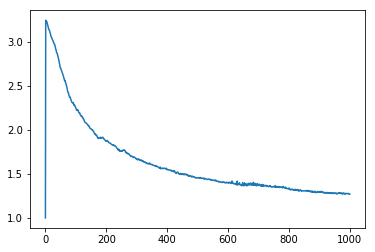

In [32]:
plt.figure()
plt.plot(np.asnumpy(hist) * -1)

#### Probs have something to do with the depth / width, at least we know it works

In [33]:
scorenn.score(smol_batch_pixels,smol_batch_label)

array(68.75)

Testing on a deeper and wider model.

According to the paper, wider is better, even at constant parameter count.

For starters, lets keep the 3 layers model, and make the hidden layers 1.25 times larger

In [34]:
newoptimizer = MomentumSGD(0.1,0.9)
newscorenn = ScoreFCNN([784,250,250,10],0.5,kaiming_uniform,kaiming_uniform,relu,crossentropy_with_logits,newoptimizer)

In [35]:
history = newscorenn.fit(train_pix,train_lab,32,30)

Epoch 0 done. Loss : -1.5410837720706656
Epoch 1 done. Loss : -0.8331827868285081
Epoch 2 done. Loss : -0.72061430549481
Epoch 3 done. Loss : -0.664491091224655
Epoch 4 done. Loss : -0.6331079629079583
Epoch 5 done. Loss : -0.6129379573998177
Epoch 6 done. Loss : -0.5966897745681198
Epoch 7 done. Loss : -0.5833934950389326
Epoch 8 done. Loss : -0.5688775422496612
Epoch 9 done. Loss : -0.5595980873396752
Epoch 10 done. Loss : -0.551634420776636
Epoch 11 done. Loss : -0.5436108081496245
Epoch 12 done. Loss : -0.5369025916453636
Epoch 13 done. Loss : -0.5310137006902936
Epoch 14 done. Loss : -0.5263946790909554
Epoch 15 done. Loss : -0.5227101023723674
Epoch 16 done. Loss : -0.5184713351217556
Epoch 17 done. Loss : -0.5137013486994436
Epoch 18 done. Loss : -0.510345059280892
Epoch 19 done. Loss : -0.5073897322844743
Epoch 20 done. Loss : -0.5043291947273818
Epoch 21 done. Loss : -0.501224583621243
Epoch 22 done. Loss : -0.4988008502092243
Epoch 23 done. Loss : -0.4966628609282628
Epoch 24

Ignore the first epoch error i messed up something for sure xd

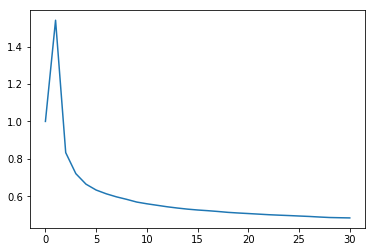

In [39]:
plt.figure()
plt.plot(np.asnumpy(history) * -1)

# Performance of Score NN

This is our performance using scoreNN. Pretty good, huh?

In [36]:
print(f"Performance on training data : {newscorenn.score(train_pix,train_lab)} %")

Performance on training data : 93.35978835978837 %


In [37]:
print(f"Performance on training data : {newscorenn.score(test_pix,test_lab) } %")

Performance on training data : 92.26190476190477 %
